# Import libraries

In [2]:
import sys
sys.path.insert(0,'..')

In [3]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt

from functools import partial
from multiprocessing import Pool

#from lhcsmapi.Time import Time
#from lhcsmapi.Timer import Timer
#from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau2_V2 import RBFPAPrimQuenchEEPlateau2_V2
from src.datasets.rb_fpa_prim_quench_ee_plateau_V2 import RBFPAPrimQuenchEEPlateau_V2
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
#from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


# Define Paths

In [4]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'

# Read the (clean) MP3 file

In [5]:
# define paths to read
context_path = Path("../data/MP3_context_data/20230313_RB_processed.csv")
snapshot_context_path = Path("../data/RB_snapshot_context.csv")

# define paths to read + write
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20230313_RBFPAPrimQuenchEEPlateau_V2")
dataset_path2 = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20230313_RBFPAPrimQuenchEEPlateau2_V2")

# load desired fpa_identifiers
mp3_fpa_df = pd.read_csv(context_path)
snapshot_context_df = pd.read_csv(snapshot_context_path)
mp3_fpa_df = pd.concat([mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= 1526582397220000000], snapshot_context_df])
drop_events = ["RB_RB.A78_1619330143440000000", "RB_RB.A45_1544355147780000000", "RB_RB.A45_1544300287820000000"] # known outliers to drop

acquisition_summary_path = Path("../data/20230313_acquisition_summary.csv")
acquisition_summary = pd.read_csv(acquisition_summary_path)
drop_events.append(acquisition_summary[acquisition_summary["U_diode_data_useable"] != 1].fpa_identifier.values)

mp3_fpa_df = mp3_fpa_df[~mp3_fpa_df.fpa_identifier.isin(drop_events)]
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3455, 731)

In [7]:
mp3_fpa_df_unique['I_Q_kA'] = mp3_fpa_df_unique["I_Q_M"].apply(lambda x: np.round(x / 1e3)*1e3)
#mp3_fpa_df_unique['dI_dt_from_data_round'] = mp3_fpa_df_unique["dI_dt_from_data"].apply(lambda x: int(np.round(x)))

mp3_fpa_df_unique['datetime'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)'])
mp3_fpa_df_unique['year'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.year)
mp3_fpa_df_unique['month'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.month)
mp3_fpa_df_unique['day'] = mp3_fpa_df_unique['datetime'].apply(lambda x: x.day)

# Read metadata

In [8]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


In [ ]:
rb_magnet_metadata

In [9]:
mp3_fpa_df_unique = mp3_fpa_df_unique.merge(rb_magnet_metadata,
                                            left_on=["Magnet"],
                                            right_on=["Magnet"],
                                            how="left", suffixes=('', '_y'))

drop_columns = mp3_fpa_df_unique.filter(regex='Unnamed').columns.to_list()
drop_columns += mp3_fpa_df_unique.filter(regex='_y').columns.to_list()
mp3_fpa_df_unique = mp3_fpa_df_unique.drop(columns=drop_columns)

# Read position map

In [10]:
pos_map_path = Path("../data/circuit_sort.csv")
df_pos_map = pd.read_csv(pos_map_path)

In [11]:
df_pos_map_subset = df_pos_map[(df_pos_map["Circuit"] == 'RB.A12') & (df_pos_map["El. Quench Position"] == 0)].reset_index(drop=True)
value_columns = df_pos_map_subset.filter(regex= ". ").columns
df_pos_map_subset[value_columns] = (df_pos_map_subset[value_columns] +1)
df_pos_map_subset.T

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
Circuit,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,...,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12,RB.A12
Magnet,MB.A8L2,MB.A9L2,MB.A10L2,MB.A11L2,MB.A12L2,MB.C12L2,MB.B13L2,MB.A14L2,MB.C14L2,MB.B15L2,...,MB.C15L2,MB.A15L2,MB.B14L2,MB.C13L2,MB.A13L2,MB.B12L2,MB.B11L2,MB.B10L2,MB.B9L2,MB.B8L2
El. Position,1,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
Phys. Position,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Dist. to PC,1,3,5,7,9,11,13,15,17,19,...,20,18,16,14,12,10,8,6,4,2
Phys. Position ODD,154,152,150,148,146,144,142,140,138,136,...,135,137,139,141,143,145,147,149,151,153
Phys. Position EVEN,2,4,6,8,10,12,14,16,18,20,...,19,17,15,13,11,9,7,5,3,1
El. Quench Position,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phys. Quench Position,154,154,154,154,154,154,154,154,154,154,...,154,154,154,154,154,154,154,154,154,154
Phys. Dist. to Quench,155,153,151,149,147,145,143,141,139,137,...,136,138,140,142,144,146,148,150,152,154


In [12]:
df_pos_map = df_pos_map.set_index(['Circuit', 'El. Quench Position', 'Phys. Quench Position']) # allows faster indexing

# Load Data

In [13]:
# load data 1EE
dataset_creator = RBFPAPrimQuenchEEPlateau_V2()
ds1 = dataset_creator.load_dataset(fpa_identifiers=mp3_fpa_df_unique.fpa_identifier.values,
                                  dataset_path=dataset_path)
# load data 1EE
dataset_creator = RBFPAPrimQuenchEEPlateau2_V2()
ds2 = dataset_creator.load_dataset(fpa_identifiers=mp3_fpa_df_unique.fpa_identifier.values,
                                  dataset_path=dataset_path2)

# append 1st and second EE Plateau
ds_detrend1 = dataset_creator.detrend_dim(ds1, deg=-1)
ds_detrend1.coords["t0"] = ds_detrend1["time"].values[0]
ds_detrend1["time"] = ds_detrend1["time"].values - ds_detrend1["time"].values[0]
ds_detrend2 = dataset_creator.detrend_dim(ds2, deg=-1)
ds_detrend2 = ds_detrend2.isel(time=slice(0, 400))
ds_detrend2.coords["t0"] = ds_detrend2["time"].values[0]
ds_detrend2["time"] = ds_detrend1["time"]
ds_detrend2.coords["plateau_number"] = 2
ds_detrend = xr.concat([ds_detrend1, ds_detrend2], dim="event")

# calculate fft
f_window = np.hanning
f_lim = (0, 534)
da_fft = get_fft_of_DataArray(data=ds_detrend.data, f_window=f_window, f_lim=f_lim)
da_fft_amplitude = scale_fft_amplitude(data=da_fft, f_window=f_window)
da_fft_amplitude = da_fft_amplitude[:, :, da_fft_amplitude.frequency < f_lim[1]]

na_fft_flat = np.nan_to_num(da_fft_amplitude.data.reshape(-1, np.shape(da_fft_amplitude.data)[2]))

## Define training data

In [17]:
# make bools of different plateaus and experiment types
test_conditions = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) &
                   (mp3_fpa_df['Nr in Q event'].astype(str) != '1'))
bool_test = np.isin(ds_detrend.event.values, mp3_fpa_df[test_conditions].fpa_identifier.unique())
snapshot_conditions = mp3_fpa_df["Date (FGC)"].isna()
bool_snapshot = np.isin(ds_detrend.event.values, mp3_fpa_df[snapshot_conditions].fpa_identifier.unique())
bool_1EE = (ds_detrend.t0.values < 0.5)
bool_2EE = (ds_detrend.t0.values > 0.5)

bool_train_flattened = np.stack([~(bool_test | bool_snapshot) for l in range(na_fft_flat.shape[1])]).T.reshape(-1)

print(f"1EE: {int(len(bool_test) / 2)} events = {int(sum(~(bool_test | bool_snapshot)) / 2)} normal + {int(sum(bool_test)/ 2)} fast sec + {int(sum(bool_snapshot)/ 2)} snapshots")

1EE: 699 events = 494 normal + 157 fast sec + 48 snapshots


# Look at data

In [80]:
def plot_feature_correlation(mp3_fpa_df_subset, column, f=np.mean):  
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    for i, m in enumerate(mp3_fpa_df_subset.sort_values(by=column)[column].dropna().unique()):

        fpa = mp3_fpa_df_unique[mp3_fpa_df_unique[column] == m].fpa_identifier.values

        data = da_fft_amplitude[np.isin(da_fft_amplitude.event.values, fpa)]
        
        data_mean = f(data, axis=1).mean(axis=0) # max over all magnets, mean over all events
        print(da_fft_amplitude.shape, data_mean.shape)
        
        ax.plot(da_fft_amplitude.frequency, data_mean, label=f"magnet {column} {m} (# signals: ({len(data)}))")
        #ax.plot(data, '.')
    
    #df.plot(marker=".", figsize=(12,7), markersize=5)
    plt.legend()
    plt.yscale("log")
    plt.ylabel("Voltage / V")
    plt.xlabel("Frequency / Hz")
    plt.title(f"{f.__name__} Voltage in Circuit, Average over all events")
    plt.grid()
    
def plot_feature_correlation_bool(bool_idx_list, legend, f=np.mean):  
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    for b in bool_idx_list:

        data = da_fft_amplitude[b]
        
        data_mean = f(data, axis=1).mean(axis=0) # max over all magnets, mean over all events
        print(da_fft_amplitude.shape, data_mean.shape)
        
        ax.plot(da_fft_amplitude.frequency, data_mean)
        #ax.plot(data, '.')
    
    plt.legend(legend)
    plt.yscale("log")
    plt.ylabel("Voltage / V")
    plt.xlabel("Frequency / Hz")
    plt.title(f"{f.__name__} Voltage in Circuit, Average over all events")
    plt.grid()

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


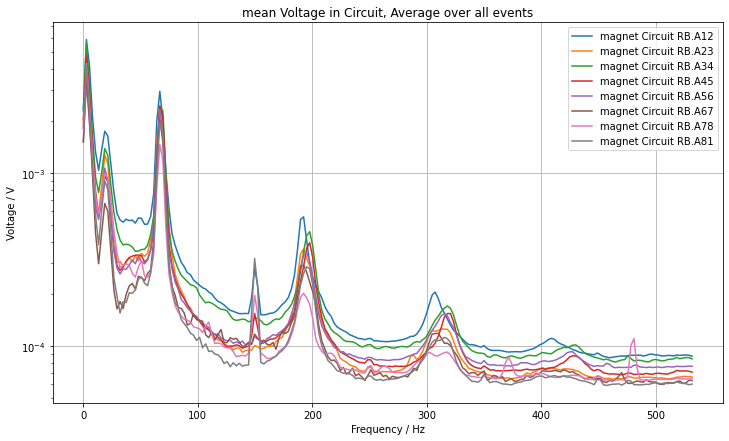

In [77]:
column = "Circuit"
plot_feature_correlation(mp3_fpa_df_unique, column)

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


<Figure size 432x288 with 0 Axes>

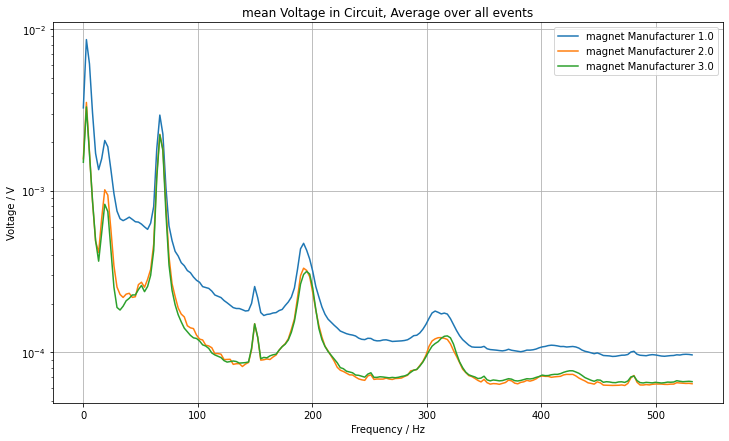

<Figure size 432x288 with 0 Axes>

In [70]:
column = "Manufacturer"
plot_feature_correlation(mp3_fpa_df_unique, column)

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


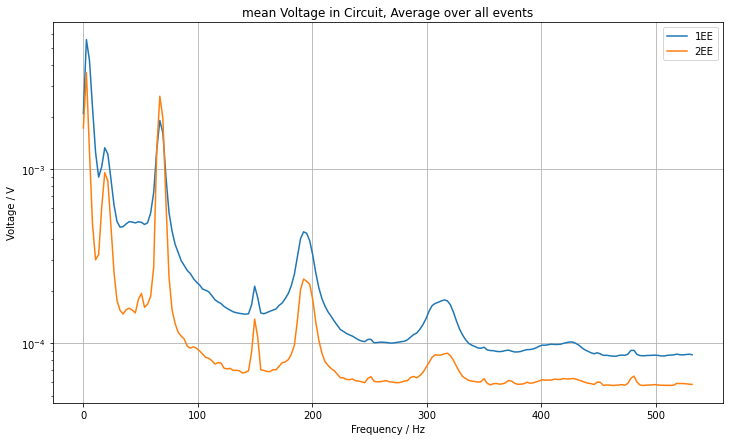

In [74]:
plot_feature_correlation_bool([bool_1EE, bool_2EE], legend=["1EE", "2EE"])

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


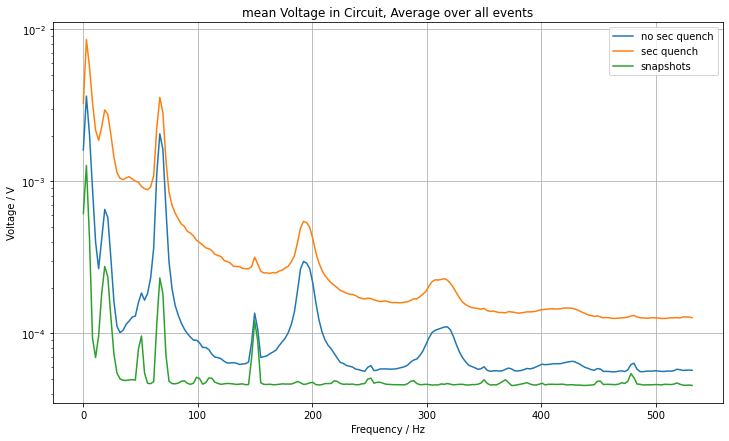

In [75]:
plot_feature_correlation_bool([~(bool_test | bool_snapshot), bool_test, bool_snapshot], legend=["no sec quench", "sec quench", "snapshots"])

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


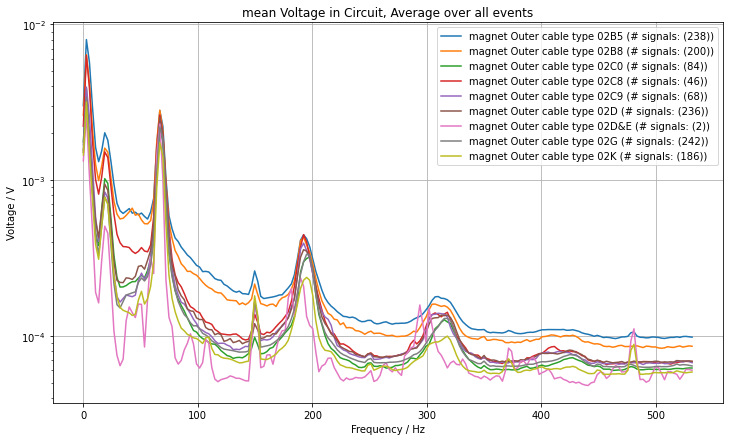

In [81]:
column = "Outer cable type"
plot_feature_correlation(mp3_fpa_df_unique, column)

(1398, 154, 200) (200,)
(1398, 154, 200) (200,)
(1398, 154, 200) (200,)


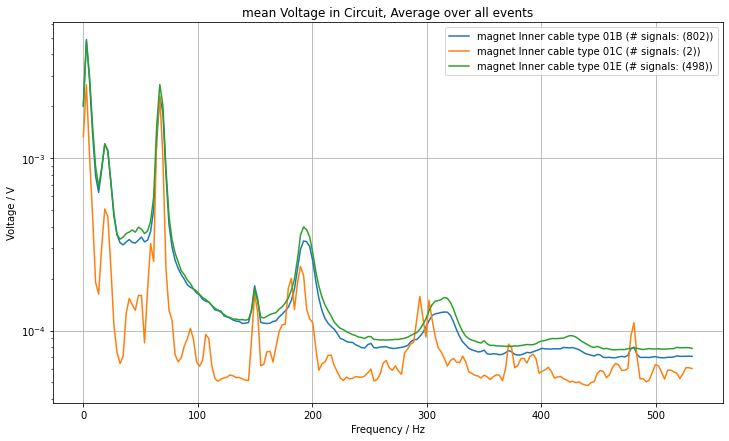

In [82]:
column = "Inner cable type"
plot_feature_correlation(mp3_fpa_df_unique, column)